In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
from transformers import BertTokenizer, XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
df = pd.read_csv(r'./news.csv')
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [3]:
title = list(df['title'])
text = list(df['text'])
news = []
for i in range(len(title)):
    news.append(title[i] + '.\n' + text[i])
labels = list(df['label'])
labels = [0 if i == 'FAKE' else 1 for i in labels]
data = (news, labels)

In [4]:
from sklearn.model_selection import train_test_split

news_train, news_test, labels_train, labels_test = train_test_split(news, labels, test_size = 0.2)
train_data = (news_train, labels_train)
test_data = (news_test, labels_test)

print('train size: ', len(train_data[0]))
print('test size: ', len(test_data[0]))

train size:  5068
test size:  1267


In [5]:
# shuffle
state = np.random.get_state()
np.random.shuffle(train_data[0])
np.random.set_state(state)
np.random.shuffle(train_data[1])


state1 = np.random.get_state()
np.random.shuffle(test_data[0])
np.random.set_state(state1)
np.random.shuffle(test_data[1])

In [6]:
# tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
# print(len(tokenizer.vocab))

In [8]:

train_input_ids = []
train_attention_masks = []

n=5068

for sentence in train_data[0][:n]:

    encoded = tokenizer.encode_plus(
        text=sentence,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length = True,
#         padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
    
    train_input_ids.append(encoded['input_ids'])
#     print(encoded['input_ids'])

    train_attention_masks.append(encoded['attention_mask'])


train_input_ids = torch.cat(train_input_ids)
train_attention_masks = torch.cat(train_attention_masks)
train_labels = torch.tensor(train_data[1][:n])
    

# # Get the input IDs and attention mask in tensor format
# input_ids = encoded['input_ids']
# attn_mask = encoded['attention_mask']


print('Original: ', train_data[0][0])
print('Token IDs:', train_input_ids[0])
print(train_labels[0])

Original:  Dilbert Creator Explains “How Do I Know The Emails Are That Bad?”.

If you’re following the news, you know FBI Director James Comey announced that the FBI found a bunch of emails on Anthony Weiner’s laptop.
As Dilbert Creator Scott Adams notes, there appears to be two main observations:
1. Comey seemed pro-Clinton when he dropped the initial email case.
2. Comey seems anti-Clinton this week because he announced a new round of investigations right before the election.
So, how can both behaviors be explained? 
First some background from Adams on ‘The Persuasion Filter’ :
As my regular readers know, the Persuasion Filter is related to the idea that the human brain never evolved to accurately comprehend reality . In order for us to be here today, our predecessors only needed to survive and procreate. They had no need to understand reality at any basic level. And we have no such need either. That’s why you might believe you are reincarnated from a monk and I might believe my prop

In [9]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)


train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,561 training samples
  507 validation samples


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 16

train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [11]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased", 
    num_labels = 2, 
                   
    output_attentions = False, 
    output_hidden_states = False, 
    return_dict=False
)


model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [12]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

from transformers import get_linear_schedule_with_warmup


epochs = 3


total_steps = len(train_dataloader) * epochs


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [13]:
import numpy as np


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''

    elapsed_rounded = int(round((elapsed)))
    

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [14]:
torch.cuda.empty_cache()

In [15]:
import random
import numpy as np


seed_val = 42
batch_size = 32
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []


total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    t0 = time.time()


    total_train_loss = 0

    
    model.train()

    for step, batch in enumerate(train_dataloader):


        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

   
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        
        optimizer.zero_grad()        


        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()


        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()


    avg_train_loss = total_train_loss / len(train_dataloader)            
    

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================


    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        
            output = model(b_input_ids, 
                                   token_type_ids=None,
                           attention_mask=b_input_mask)
            

        #total_eval_loss += loss.item()
        logits = output[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 计算准确率
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #avg_val_loss = total_eval_loss / len(validation_dataloader)
    

    validation_time = format_time(time.time() - t0)
    
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

   
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            #'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    286.    Elapsed: 0:00:07.
  Batch    80  of    286.    Elapsed: 0:00:13.
  Batch   120  of    286.    Elapsed: 0:00:20.
  Batch   160  of    286.    Elapsed: 0:00:26.
  Batch   200  of    286.    Elapsed: 0:00:32.
  Batch   240  of    286.    Elapsed: 0:00:39.
  Batch   280  of    286.    Elapsed: 0:00:45.

  Average training loss: 0.26
  Training epcoh took: 0:00:46

Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:01

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    286.    Elapsed: 0:00:06.
  Batch    80  of    286.    Elapsed: 0:00:13.
  Batch   120  of    286.    Elapsed: 0:00:19.
  Batch   160  of    286.    Elapsed: 0:00:26.
  Batch   200  of    286.    Elapsed: 0:00:32.
  Batch   240  of    286.    Elapsed: 0:00:38.
  Batch   280  of    286.    Elapsed: 0:00:45.

  Average training loss: 0.10
  Training epcoh took: 0:00:46

Running Validation...
  Accuracy: 0.96
  Validation took: 0:00:0

In [16]:
import pandas as pd


pd.set_option('precision', 2)


df_stats = pd.DataFrame(data=training_stats)


df_stats = df_stats.set_index('epoch')


df_stats



,Training Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,
1,0.26,0.95,0:00:46,0:00:01
2,0.10,0.96,0:00:46,0:00:01
3,0.04,0.97,0:00:45,0:00:01


In [18]:

test_input_ids = []
test_attention_masks = []

n = 1267
for sentence in test_data[0][:n]:
    encoded = tokenizer.encode_plus(
        text=sentence,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length = True,
#         padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
  
    test_input_ids.append(encoded['input_ids'])
#     print(encoded['input_ids'])
  
    test_attention_masks.append(encoded['attention_mask'])


test_input_ids = torch.cat(test_input_ids)
test_attention_masks = torch.cat(test_attention_masks)
test_labels = torch.tensor(test_data[1][:n])

batch_size = 32  

prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:


print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

model.eval()

# Tracking variables 
predictions , true_labels = [], []


for batch in prediction_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch


    with torch.no_grad():

      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]


    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #total_eval_accuracy += flat_accuracy(logits, label_ids)



    predictions.append(logits)
    true_labels.append(label_ids)
#avg_val_accuracy = flat_accuracy(predictions, true_labels)    
#avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
#print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
print('    DONE.')

Predicting labels for 1,267 test sentences...
    DONE.


In [20]:
print('Positive samples: %d of %d (%.2f%%)' % (sum(test_data[1]), len(test_data[1]), (sum(test_data[1]) / len(test_data[1]) * 100.0)))


Positive samples: 605 of 1267 (47.75%)


In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pred_labels_i = []
# For each input batch...
for i in range(len(true_labels)):
    pred_labels_i += list(np.argmax(predictions[i], axis=1).flatten())

    
true_labels_list = []
for i in test_labels:
    true_labels_list.append(i.item())

accuracy_score(pred_labels_i, true_labels_list)

0.9723756906077348

Classification Report:
              precision    recall  f1-score   support

           1     0.9597    0.9835    0.9714       605
           0     0.9845    0.9622    0.9733       662

    accuracy                         0.9724      1267
   macro avg     0.9721    0.9729    0.9723      1267
weighted avg     0.9727    0.9724    0.9724      1267



[Text(0, 0.5, 'POS'), Text(0, 1.5, 'NEG')]

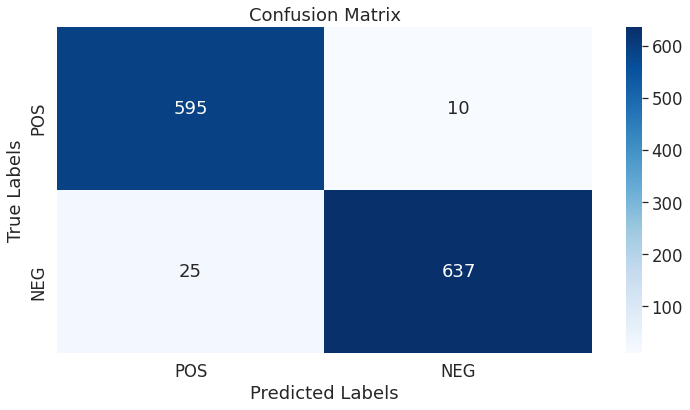

In [23]:
print('Classification Report:') 
print(classification_report(true_labels_list, pred_labels_i, labels=[1,0], digits=4)) 

cm = confusion_matrix(true_labels_list, pred_labels_i, labels=[1,0]) 
ax= plt.subplot() 
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d") 
ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 
ax.xaxis.set_ticklabels(['POS', 'NEG']) 
ax.yaxis.set_ticklabels(['POS', 'NEG']) 